## CH5S4: Multivariate Copulas for Claim Sites

This script will be divided in the following parts:
    
1. Fitting multivariate copulas for raw claim sites
2. Simulations to obtain VaR and TVaR with parametric copulas 
3. Comparison between Empirical marginals vs. Parametric marginals


In [1]:
#loading the required libraries:
import numpy as np
import itertools
import random
from statistics import mean 
import tqdm
from tqdm import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copulae
import scipy.stats as ss

#changing the plot configuration:
plt.rcParams['figure.figsize'] = (5, 5)
plt.style.use('seaborn')

### 1. Fitting multivariate copulas for raw claim sites

In [2]:
#loading the raw claims dataset:
df = pd.read_csv("C:/Users/r_jun/Documents/ISEG MSc Actuarial Science/Thesis/Python/FINAL/CH4/Raw by Type/aggregated_series.csv")

#adding the marginals of the raw claim sites:
df['Fcbx'] = ss.nbinom.cdf(df['cbx'], 1.3966908444521602, 0.003585989036498995)
df['Fcpx'] = ss.nbinom.cdf(df['cpx'], 4.676652646199874, 0.03724209891451029)
df['Fcbs'] = ss.loglaplace.cdf(df['cbs'], 1.4149894458208154, 0, 30811.296859671424)
df['Fcps'] = ss.loglaplace.cdf(df['cps'],  2.470615641302211, 0, 34138.78552976878)
df.head()

,Date,pdx,pds,plx,pls,cbx,cbs,cpx,cps,Fcbx,Fcpx,Fcbs,Fcps
0,2003-01-01,258,47806.22,162,48506.85,160,25260.04,287,83758.85,0.271710,0.989218,0.377477,0.945554
1,2003-02-01,349,55287.03,204,48309.05,376,56751.91,200,52267.65,0.598800,0.907123,0.789324,0.825441
2,2003-03-01,375,62232.51,334,81314.60,495,82218.08,224,60334.01,0.719123,0.946840,0.875313,0.877552
3,2003-04-01,402,71880.07,413,90177.39,688,112881.10,154,52320.24,0.845961,0.756486,0.920376,0.825874
4,2003-05-01,372,61494.99,325,68181.76,592,99571.28,154,41398.91,0.791736,0.756486,0.904909,0.689488


**I. FITTING THE GAUSSIAN COPULA:**

In [3]:
from copulae import GaussianCopula

#setting the dimensions:
_, ndim = df.iloc[:,9:].shape

#initializing the copula:
g_cop = GaussianCopula(dim=ndim) 

#fitting the copula to the marginals:
g_cop.fit(df.iloc[:,9:], to_pobs=False)

#printing the log-likelihood:
print(g_cop.log_lik(df.iloc[:,9:],to_pobs=False))

376.84146362452725


In [4]:
g_cop.summary()

1.000000,0.861230,0.926686,0.717707
0.861230,1.000000,0.855083,0.870831
0.926686,0.855083,1.000000,0.713297
0.717707,0.870831,0.713297,1.000000


**II. FITTING THE T COPULA:**

In [5]:
from copulae import StudentCopula

#setting the dimensions:
t_cop = StudentCopula(dim=ndim)

#initializing the copula:
t_cop.fit(df.iloc[:,9:])

#printing the log-likelihood and the parameter:
print(t_cop.log_lik(df.iloc[:,9:], to_pobs=False), t_cop.params[0])

298.8152097040312 3.6553961150342027


In [6]:
t_cop.summary()

1.000000,0.864712,0.975630,0.688254
0.864712,1.000000,0.857299,0.849682
0.975630,0.857299,1.000000,0.684770
0.688254,0.849682,0.684770,1.000000


**III. FITTING THE CLAYTON COPULA:**

In [7]:
from copulae import ClaytonCopula

#initalizing the copula:
cl_cop = ClaytonCopula(dim=ndim)

#fitting the copula:
cl_cop.fit(df.iloc[:,9:], to_pobs=False)
print(cl_cop.log_lik(df.iloc[:,9:], to_pobs=False), cl_cop.params)

247.85069481586737 2.008485457879619


**IV. FITTING THE FRANK COPULA:**

In [8]:
from copulae import FrankCopula

#initalizing the copula:
frank_cop = FrankCopula(dim=ndim)

#fitting the copula:
frank_cop.fit(df.iloc[:,9:], to_pobs=False)
print(frank_cop.log_lik(df.iloc[:,9:], to_pobs=False), frank_cop.params)

290.78371111039803 8.239918764871803


**V. FITTING THE GUMBEL COPULA:**

In [9]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
from copulae import GumbelCopula

#initalizing the copula:
gu_cop = GumbelCopula(dim=ndim)

#fitting the copula:
gu_cop.fit(df.iloc[:,9:], to_pobs=False)
print(gu_cop.log_lik(df.iloc[:,9:], to_pobs=False), gu_cop.params)

271.37130593035715 2.246702698769599


### 2. Simulations to obtain VaR and TVaR with parametric copulas


In [10]:
#making a VaR function:
def VAR(series, CL):
    return series.quantile(CL, axis=0)

#and a Tail VaR function and calling it CTE:
def TVAR(series, ci):
    var = VAR(series, ci)	
    return series[series.gt(var, axis=1)].mean()


In [11]:
#testing the VaR function:
VAR(df.iloc[:,[6,8]],0.99)

cbs    252357.2935
cps     83655.8020
Name: 0.99, dtype: float64

In [25]:
######################################################## GAUSSIAN COPULA SIMULATION#########
pi = [0.95, 0.955, 0.96, 0.965, 0.97, 0.975, 0.98, 0.985, 0.99, 0.995]

#generating 10000 simulations:
sims = {}
for it in range(0,10000):
    sims[it] = g_cop.random(len(df))

#finding the inverse of the simulated series:
for key in sims:
    sims[key]['cbs'] =  ss.loglaplace.ppf(sims[key]['Fcbs'], 1.4149894458208154, 0, 30811.296859671424)
    sims[key]['cps'] =  ss.loglaplace.ppf(sims[key]['Fcps'], 2.470615641302211, 0, 34138.78552976878)

    
#creating VaR and TVaR dictionaries from the simulations:
vcb1 = []
tvcb1 = []
vcp1 = []
tvcp1 = []
for p in tqdm(pi):
    vi = {}
    vi2 = {}
    tvi = {}
    tvi2 = {}
    for key in sims:
        vi = list(VAR(sims[key].iloc[:,[4]], p))
        vi2 = list(VAR(sims[key].iloc[:,[5]], p))
        tvi = list(TVAR(sims[key].iloc[:,[4]], p))
        tvi2 = list(TVAR(sims[key].iloc[:,[5]], p))
    vcb1.append(mean(vi))
    vcp1.append(mean(vi2))
    tvcb1.append(mean(tvi))
    tvcp1.append(mean(tvi2))

######################################################## STUDENT T COPULA SIMULATION#########

#generating 10000 simulations:
sims = {}
for it in range(0,10000):
    sims[it] = t_cop.random(len(df))

for key in sims:
    sims[key]['cbs'] =  ss.loglaplace.ppf(sims[key]['Fcbs'], 1.4149894458208154, 0, 30811.296859671424)
    sims[key]['cps'] =  ss.loglaplace.ppf(sims[key]['Fcps'], 2.470615641302211, 0, 34138.78552976878)
    
#creating VaR and TVaR dictionaries from the simulations:
vcb2 = []
tvcb2 = []
vcp2 = []
tvcp2 = []
for p in tqdm(pi):
    vi = {}
    vi2 = {}
    tvi = {}
    tvi2 = {}
    for key in sims:
        vi = list(VAR(sims[key].iloc[:,[4]], p))
        vi2 = list(VAR(sims[key].iloc[:,[5]], p))
        tvi = list(TVAR(sims[key].iloc[:,[4]], p))
        tvi2 = list(TVAR(sims[key].iloc[:,[5]], p))
    vcb2.append(mean(vi))
    vcp2.append(mean(vi2))
    tvcb2.append(mean(tvi))
    tvcp2.append(mean(tvi2))

######################################################## CLAYTON COPULA SIMULATION#########

#generating 10000 simulations:
sims = {}
for it in range(0,10000):
    sims[it] = cl_cop.random(len(df))

for key in sims:
    sims[key]['cbs'] =  ss.loglaplace.ppf(sims[key]['Fcbs'], 1.4149894458208154, 0, 30811.296859671424)
    sims[key]['cps'] =  ss.loglaplace.ppf(sims[key]['Fcps'], 2.470615641302211, 0, 34138.78552976878)
    
#creating VaR and TVaR dictionaries from the simulations:
vcb3 = []
tvcb3 = []
vcp3 = []
tvcp3 = []
for p in tqdm(pi):
    vi = {}
    vi2 = {}
    tvi = {}
    tvi2 = {}
    for key in sims:
        vi = list(VAR(sims[key].iloc[:,[4]], p))
        vi2 = list(VAR(sims[key].iloc[:,[5]], p))
        tvi = list(TVAR(sims[key].iloc[:,[4]], p))
        tvi2 = list(TVAR(sims[key].iloc[:,[5]], p))
    vcb3.append(mean(vi))
    vcp3.append(mean(vi2))
    tvcb3.append(mean(tvi))
    tvcp3.append(mean(tvi2))

######################################################## GUMBEL COPULA SIMULATION#########

#generating 10000 simulations:
sims = {}
for it in range(0,10000):
    sims[it] = gu_cop.random(len(df))

for key in sims:
    sims[key]['cbs'] =  ss.loglaplace.ppf(sims[key]['Fcbs'], 1.4149894458208154, 0, 30811.296859671424)
    sims[key]['cps'] =  ss.loglaplace.ppf(sims[key]['Fcps'], 2.470615641302211, 0, 34138.78552976878)
    
#creating VaR and TVaR dictionaries from the simulations:
vcb4 = []
tvcb4 = []
vcp4 = []
tvcp4 = []
for p in tqdm(pi):
    vi = {}
    vi2 = {}
    tvi = {}
    tvi2 = {}
    for key in sims:
        vi = list(VAR(sims[key].iloc[:,[4]], p))
        vi2 = list(VAR(sims[key].iloc[:,[5]], p))
        tvi = list(TVAR(sims[key].iloc[:,[4]], p))
        tvi2 = list(TVAR(sims[key].iloc[:,[5]], p))
    vcb4.append(mean(vi))
    vcp4.append(mean(vi2))
    tvcb4.append(mean(tvi))
    tvcp4.append(mean(tvi2))
    


############################################# INDEPENDENCE COPULA ##################### 
from copulae import IndepCopula
icop = IndepCopula(dim=ndim)
icop.fit(df.iloc[:,9:])

#generating 10000 simulations:
sims = {}
for it in range(0,10000):
    sims[it] = icop.random(len(df))

#finding the inverse of the simulated series:
CBS = {}
CPS = {}
for key in sims:
    CBS[key] =  ss.loglaplace.ppf(sims[key][:,2], 1.4149894458208154, 0, 30811.296859671424)
    CPS[key] =  ss.loglaplace.ppf(sims[key][:,3], 2.470615641302211, 0, 34138.78552976878)

    
    

#creating VaR and TVaR dictionaries for the simulations for PLS:
vcb5 = []
tvcb5 = []
for p in tqdm(pi):
    var_cbs = {}
    tvar_cbs = {}
    for key in CBS:
        var_cbs[key] = np.quantile(CBS[key], p, axis = 0)
        tvar_cbs[key] = CBS[key][CBS[key] >= var_cbs[key]].mean()
    vcb5.append(mean(list(var_cbs.values())))
    tvcb5.append(mean(list(tvar_cbs.values())))

#creating VaR and TVaR dictionaries for the simulations for PDS:
vcp5 = []
tvcp5 = []
for p in tqdm(pi):
    var_cps = {}
    tvar_cps = {}
    for key in CPS:
        var_cps[key] = np.quantile(CPS[key], p, axis = 0)
        tvar_cps[key] = CPS[key][CPS[key] >= var_cps[key]].mean()
    vcp5.append(mean(list(var_cps.values())))
    tvcp5.append(mean(list(tvar_cps.values())))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.29s/it]


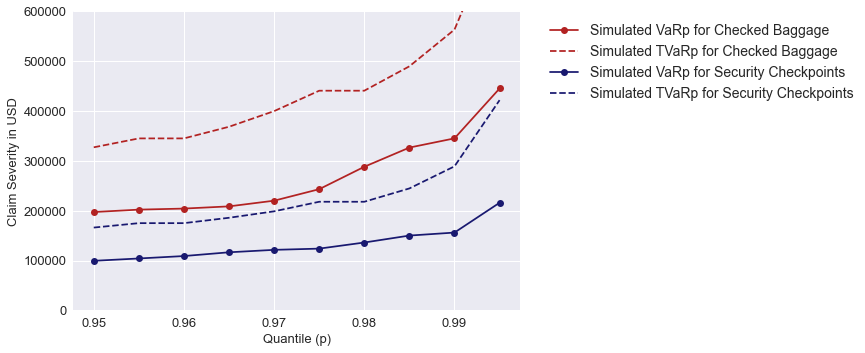

In [26]:
#comparative graph for VaR of checked baggageand security checkpoint with Gumbel copula:
#VaR plot:
plt.rcParams['figure.figsize'] = (9, 6)
plt.style.use('seaborn') 
plt.plot(pi, vcb4, 'y-o', color="firebrick", label="Simulated VaRp for Checked Baggage")
plt.plot(pi, tvcb4, '--', color="firebrick", label="Simulated TVaRp for Checked Baggage")
plt.plot(pi, vcp4, 'y-o', color="midnightblue", label="Simulated VaRp for Security Checkpoints")
plt.plot(pi, tvcp4, '--', color="midnightblue", label="Simulated TVaRp for Security Checkpoints")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",fontsize=14)
plt.xlabel("Quantile (p)", fontsize=13) 
plt.ylabel("Claim Severity in USD", fontsize=13)
plt.ylim(0, 600000)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.savefig('basic_comparison_sites.png', dpi=300, bbox_inches='tight')

**Making the graphs for the Checked Baggage Severity:**

In [27]:
#HISTORICAL VAR AND TVAR for CBS:
hvar = []
for c in pi:
    hvar.append(VAR(df.iloc[:,[6]],c))
    
htvar = []
for c in pi:
    htvar.append(TVAR(df.iloc[:,[6]],c))

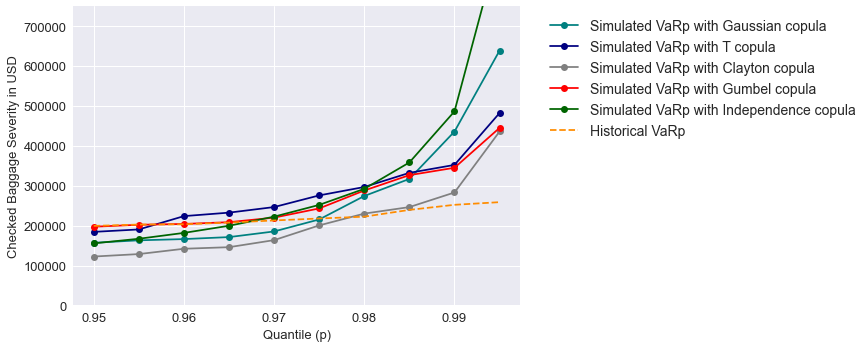

In [28]:
#VaR plot:
plt.rcParams['figure.figsize'] = (9, 6)
plt.style.use('seaborn') 
plt.plot(pi, vcb1, 'y-o', color="teal", label="Simulated VaRp with Gaussian copula")
plt.plot(pi, vcb2, 'y-o', color="navy", label="Simulated VaRp with T copula")
plt.plot(pi, vcb3, 'y-o', color="gray", label="Simulated VaRp with Clayton copula")
plt.plot(pi, vcb4, 'y-o', color="red", label="Simulated VaRp with Gumbel copula")
plt.plot(pi, vcb5, 'y-o', color="darkgreen", label="Simulated VaRp with Independence copula")
plt.plot(pi, hvar, '--', color="darkorange", label="Historical VaRp")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",fontsize=14)
plt.xlabel("Quantile (p)", fontsize=13) 
plt.ylabel("Checked Baggage Severity in USD", fontsize=13)
plt.ylim(0, 750000)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.savefig('cbs_var.png', dpi=300, bbox_inches='tight')

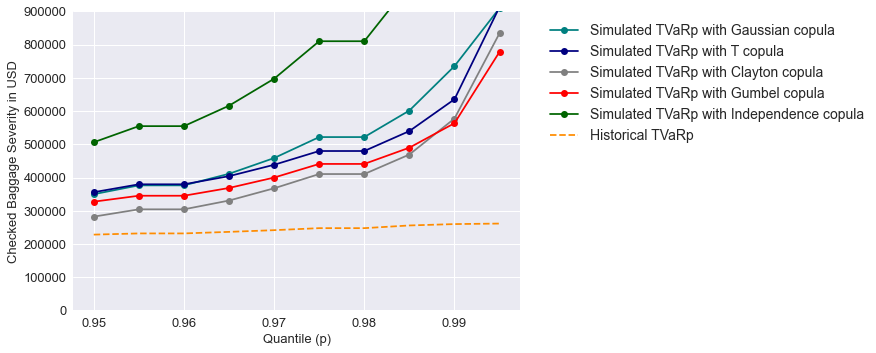

In [30]:
#TVaR plot:
plt.rcParams['figure.figsize'] = (9, 6)
plt.style.use('seaborn') 
plt.plot(pi, tvcb1, 'y-o', color="teal", label="Simulated TVaRp with Gaussian copula")
plt.plot(pi, tvcb2, 'y-o', color="navy", label="Simulated TVaRp with T copula")
plt.plot(pi, tvcb3, 'y-o', color="gray", label="Simulated TVaRp with Clayton copula")
plt.plot(pi, tvcb4, 'y-o', color="red", label="Simulated TVaRp with Gumbel copula")
plt.plot(pi, tvcb5, 'y-o', color="darkgreen", label="Simulated TVaRp with Independence copula")
plt.plot(pi, htvar, '--', color="darkorange", label="Historical TVaRp")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",fontsize=14)
plt.xlabel("Quantile (p)", fontsize=13) 
plt.ylabel("Checked Baggage Severity in USD", fontsize=13)
plt.ylim(0, 900000)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.savefig('cbs_tvar.png', dpi=300, bbox_inches='tight')

**Making the graphs for the Security Checkpoint Severity:**

In [31]:
#HISTORICAL VAR AND TVAR for CPS:
hvar2 = []
for c in pi:
    hvar2.append(VAR(df.iloc[:,[8]],c))
    
htvar2 = []
for c in pi:
    htvar2.append(TVAR(df.iloc[:,[8]],c))

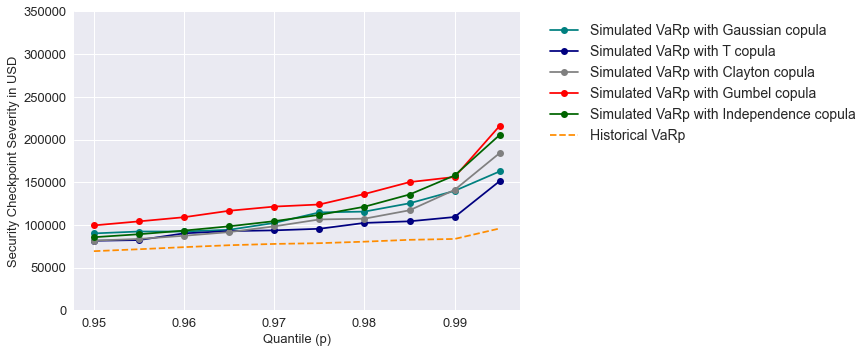

In [50]:
#VaR plot for CPS:
plt.rcParams['figure.figsize'] = (9, 6)
plt.style.use('seaborn') 
plt.plot(pi, vcp1, 'y-o', color="teal", label="Simulated VaRp with Gaussian copula")
plt.plot(pi, vcp2, 'y-o', color="navy", label="Simulated VaRp with T copula")
plt.plot(pi, vcp3, 'y-o', color="gray", label="Simulated VaRp with Clayton copula")
plt.plot(pi, vcp4, 'y-o', color="red", label="Simulated VaRp with Gumbel copula")
plt.plot(pi, vcp5, 'y-o', color="darkgreen", label="Simulated VaRp with Independence copula")
plt.plot(pi, hvar2, '--', color="darkorange", label="Historical VaRp")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",fontsize=14)
plt.xlabel("Quantile (p)", fontsize=13) 
plt.ylabel("Security Checkpoint Severity in USD", fontsize=13)
plt.ylim(0, 350000)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.savefig('cps_var.png', dpi=300, bbox_inches='tight')

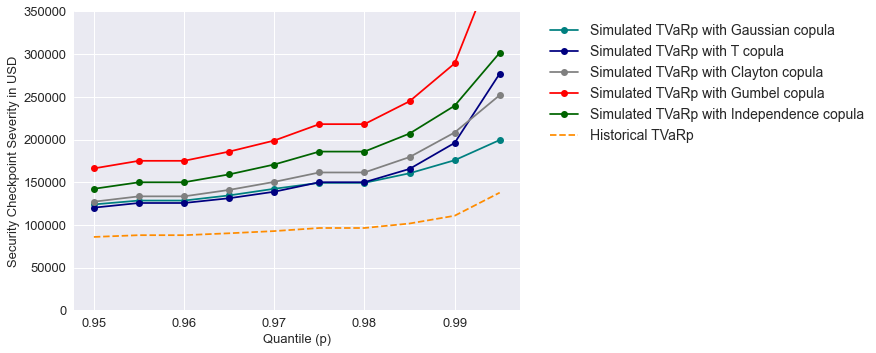

In [51]:
#TVaR plot for CPS:
plt.rcParams['figure.figsize'] = (9, 6)
plt.style.use('seaborn') 
plt.plot(pi, tvcp1, 'y-o', color="teal", label="Simulated TVaRp with Gaussian copula")
plt.plot(pi, tvcp2, 'y-o', color="navy", label="Simulated TVaRp with T copula")
plt.plot(pi, tvcp3, 'y-o', color="gray", label="Simulated TVaRp with Clayton copula")
plt.plot(pi, tvcp4, 'y-o', color="red", label="Simulated TVaRp with Gumbel copula")
plt.plot(pi, tvcp5, 'y-o', color="darkgreen", label="Simulated TVaRp with Independence copula")
plt.plot(pi, htvar2, '--', color="darkorange", label="Historical TVaRp")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",fontsize=14)
plt.xlabel("Quantile (p)", fontsize=13) 
plt.ylabel("Security Checkpoint Severity in USD", fontsize=13)
plt.ylim(0, 350000)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.savefig('cps_tvar.png', dpi=300, bbox_inches='tight')

In [38]:
#historical estimates:
hvar[-1], htvar[-1], hvar2[-1], htvar2[-1]

(cbs    259019.58175
 Name: 0.995, dtype: float64,
 cbs    261424.43
 dtype: float64,
 cps    95929.5815
 Name: 0.995, dtype: float64,
 cps    137850.99
 dtype: float64)

In [39]:
#summary:
ftable = pd.DataFrame({'Risk Measure': ['VaR Checked Baggage', 'VaR Security Checkpoint', 'TVaR Checked Baggage', 'TVaR Security Checkpoint'],
                       'Historical' : [259019.58175, 95929.5815, 261424.43,  137850.99],
                      'Gaussian' : [vcb1[-1], vcp1[-1], tvcb1[-1], tvcp1[-1]],
                      'Student t' : [vcb2[-1], vcp2[-1], tvcb2[-1], tvcp2[-1]],
                      'Clayton' : [vcb3[-1], vcp3[-1], tvcb3[-1], tvcp3[-1]],
                     'Gumbel' : [vcb4[-1], vcp4[-1], tvcb4[-1], tvcp4[-1]],
                      'Independence' : [vcb5[-1], vcp5[-1], tvcb5[-1], tvcp5[-1]]})
ftable.head()

,Risk Measure,Historical,Gaussian,Student t,Clayton,Gumbel,Independence
0,VaR Checked Baggage,259019.58175,639220.337533,482656.165804,436257.963956,445350.780077,9.091564e+05
1,VaR Security Checkpoint,95929.58150,162753.201731,151395.556423,184214.745701,216060.155215,2.054307e+05
2,TVaR Checked Baggage,261424.43000,910176.523006,913644.309764,834543.759255,778463.958626,1.948297e+06
3,TVaR Security Checkpoint,137850.99000,199462.252532,277221.589143,251982.852501,421945.040237,3.016126e+05


In [40]:
 [vcb5[-1], vcp5[-1], tvcb5[-1], tvcp5[-1]]

[909156.413773153, 205430.66635849857, 1948296.7802413998, 301612.5735486074]

### 3. Comparison between Empirical marginals vs. Log-Laplace marginals for CPS

In [41]:
#making the empirical distributions:
from statsmodels.distributions.empirical_distribution import ECDF

E1 = ECDF(df['cbs'])
ecbs = list(E1(df['cbs']))

E2 = ECDF(df['cps'])
ecps = list(E2(df['cps']))

E3 = ECDF(df['cbx'])
ecbx = list(E3(df['cbx']))

E4 = ECDF(df['cpx'])
ecpx = list(E4(df['cpx']))

dfemp = pd.DataFrame({'ECBX': ecbx, 'ECPX' : ecpx, 'ECBS': ecbs, 'ECPS': ecps})

dfemp.head()

,ECBX,ECPX,ECBS,ECPS
0,0.282051,0.993590,0.307692,0.993590
1,0.666667,0.891026,0.705128,0.826923
2,0.737179,0.955128,0.782051,0.903846
3,0.820513,0.801282,0.846154,0.833333
4,0.794872,0.801282,0.820513,0.679487


In [42]:
#fiting a Gumbel copula for the empirical marginals:
from copulae import GumbelCopula
#setting the dimensions:
_, ndim = dfemp.shape
#setting the dimensions:
gucop2 = GumbelCopula(dim=ndim)

#initializing the copula:
gucop2.fit(dfemp)

#printing the log-likelihood and the parameter:
print(gucop2.log_lik(dfemp, to_pobs=False), gucop2.params)

-inf 2.4447377590861024


In [48]:
###################################### EMPIRICAL MARGINALS WITH GUMBEL COPULA SIMULATION#########
pi = [0.95, 0.955, 0.96, 0.965, 0.97, 0.975, 0.98, 0.985, 0.99, 0.995]

#generating 10000 simulations:
sims = {}
for it in range(0,10000):
    sims[it] = gucop2.random(len(dfemp))

CBS = {}
for key in tqdm(sims):
    CBS[key] = np.quantile(df['cbs'], sims[key].iloc[:,2])
    

#creating VaR and TVaR dictionaries for the simulations for CBS:
vcb = []
tvcb = []
for p in tqdm(pi):
    var_cbs = {}
    tvar_cbs = {}
    for key in CBS:
        var_cbs[key] = np.quantile(CBS[key], p, axis = 0)
        tvar_cbs[key] = CBS[key][CBS[key] >= var_cbs[key]].mean()
    vcb.append(mean(list(var_cbs.values())))
    tvcb.append(mean(list(tvar_cbs.values())))
    
CPS = {}
for key in tqdm(sims):
    CPS[key] = np.quantile(df['cps'], sims[key].iloc[:,3])
    

#creating VaR and TVaR dictionaries for the simulations for CPS:
vcp = []
tvcp = []
for p in tqdm(pi):
    var_cps = {}
    tvar_cps = {}
    for key in CPS:
        var_cps[key] = np.quantile(CPS[key], p, axis = 0)
        tvar_cps[key] = CPS[key][CPS[key] >= var_cps[key]].mean()
    vcp.append(mean(list(var_cps.values())))
    tvcp.append(mean(list(tvar_cps.values())))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.40s/it]


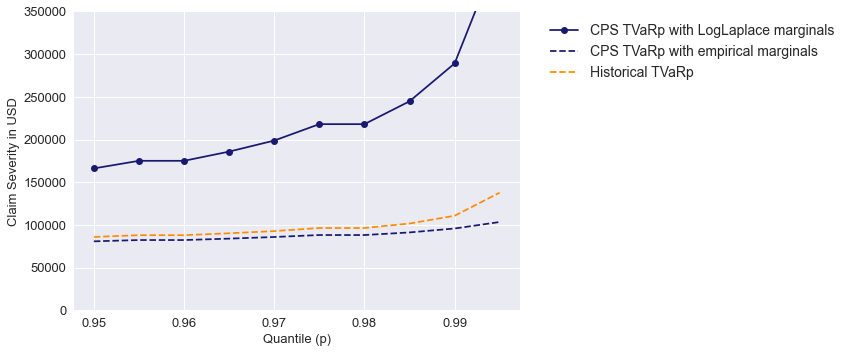

In [53]:
# graphical comparison for security checkpoits 
plt.plot(pi, tvcp4, 'y-o', color="midnightblue", label="CPS TVaRp with LogLaplace marginals")
plt.plot(pi, tvcp, '--', color="midnightblue", label="CPS TVaRp with empirical marginals")
plt.plot(pi, htvar2, '--', color="darkorange", label="Historical TVaRp")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",fontsize=14)
plt.xlabel("Quantile (p)", fontsize=13) 
plt.ylabel("Claim Severity in USD", fontsize=13)
plt.ylim(0, 350000)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.savefig('empirical_comparison_sites.png', dpi=300, bbox_inches='tight')